# Import libraries

In [ ]:
!pip install swifter -qq
!pip install -U spacy -qq
!pip install xgboost

     |████████████████████████████████| 633 kB 4.0 MB/s 
     |████████████████████████████████| 280 kB 46.0 MB/s 
     |████████████████████████████████| 134 kB 44.0 MB/s 
     |████████████████████████████████| 6.0 MB 3.9 MB/s 
     |████████████████████████████████| 628 kB 34.0 MB/s 
     |████████████████████████████████| 451 kB 6.9 MB/s 
     |████████████████████████████████| 10.1 MB 23.0 MB/s 
     |████████████████████████████████| 42 kB 1.0 MB/s 
     |████████████████████████████████| 181 kB 43.7 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys
import re
import swifter
import spacy
import joblib

from xgboost import XGBClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, fbeta_score
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer

from scipy.sparse import csr_matrix

In [ ]:
!python -m spacy download en_core_web_sm -qq

     |████████████████████████████████| 13.9 MB 266 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Mount GDrive

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
folder = Path("/content/drive/MyDrive/BUAN 6342 - Natural Language Processing/Assignments/Assignment 3")

# Import Custom Functions

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Custom_Functions')
import custom_preprocessor as cp
from  plot_learning_curve import plot_learning_curve
from featurizer import ManualFeatures

In [ ]:
def test_eval(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print('\nTest set classification report:\n', classification_report(y_test, y_pred))
    print('\nF 0.5 Score: ', fbeta_score(y_test, y_pred, beta=0.5))

In [ ]:
class SparseTransformer(TransformerMixin, BaseEstimator):
    
  def __init__(self):
    return None

  def fit(self, X, y=None):
      return self

  def transform(self, X, y=None):
      return csr_matrix(X)

# Create instances

In [ ]:
tfidvectorizer = TfidfVectorizer()
countvectorizer = CountVectorizer()
featurizer =  ManualFeatures(spacy_model='en_core_web_sm')

# Load dataset

In [ ]:
data = pd.read_csv(folder/"spam.csv")

In [ ]:
data.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Remove unwanted columns

In [ ]:
data = data.iloc[:,0:2]

# Renaming of columns

In [ ]:
data.columns = ['label','message']

# Percentage of ham and spam

In [ ]:
data.label.value_counts()/len(data['label'])*100

ham     86.593683
spam    13.406317
Name: label, dtype: float64

In [ ]:
data.sample(5)

,label,message
4456,ham,Aight should I just plan to come up later toni...
690,ham,Was the farm open?
944,ham,I sent my scores to sophas and i had to do sec...
3768,ham,Was gr8 to see that message. So when r u leavi...
1189,ham,In that case I guess I'll see you at campus lodge


# Model evaluation metric

In the Spam detection task, we classify email as spam or not spam. An email marked as spam goes into a separate folder in the mail box, which is often left unobserved by users. So, our goal should be to classify spam email correctly without making mistakes of marking non spam emails as spam. That means our True positive rate should be high or Precision should be high. Precision is the ratio of True Positive to True Positive + False Positive. Since in our model we do not want False Positives, i.e. we do not want non-spams to be classified as spams, we will try to keep False Positive very less, which would increase the Precision.<br>
Since our dataset is highly imbalanced, likeliness of predicting the negative class is high and predicting the positive class is lower. That means, we also have to reduce False Negative or keep our Recall high<br>
But we want to stress more on Precision, therefore the best metric should be F0.5 Measure.

# Convert class to numeric

In [ ]:
data.head(5)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
data['label'] = pd.factorize(data['label'])[0]

# Check the dataset

In [ ]:
sum(data['message'].swifter.apply(lambda x: int(re.search(r'@',x) != None)))

Pandas Apply:   0%|          | 0/5572 [00:00<?, ?it/s]

33

In [ ]:
sum(data['message'].swifter.apply(lambda x: int(re.search(r'#',x) != None)))

Pandas Apply:   0%|          | 0/5572 [00:00<?, ?it/s]

220

# Subset Data

In [ ]:
data_subset = data.sample(round(0.4 * len(data)), random_state = 123)

# Train Valid Split

In [ ]:
y = data_subset.label
X = data_subset.drop(columns=['label'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X['message'].values, y, test_size=0.3, stratify = y, random_state=123)

In [ ]:
print(f'Length X_train: {len(X_train)}')
print(f'Length X_test: {len(X_test)}')
print(f'Length y_train: {len(y_train)}')
print(f'Length y_test: {len(y_test)}')
print('\nY train count of values')
print(y_train.value_counts())
print('\nY train percentage of values')
print(y_train.value_counts()/len(y_train))
print('\nY valid count of values')
print(y_test.value_counts())
print('\nY valid percentage of values')
print(y_test.value_counts()/len(y_test))

Length X_train: 1560
Length X_test: 669
Length y_train: 1560
Length y_test: 669

Y train count of values
0    1358
1     202
Name: label, dtype: int64

Y train percentage of values
0    0.870513
1    0.129487
Name: label, dtype: float64

Y valid count of values
0    583
1     86
Name: label, dtype: int64

Y valid percentage of values
0    0.87145
1    0.12855
Name: label, dtype: float64


# Preprocessing

In [ ]:
X_train_clean = cp.SpacyPreprocessor(model = 'en_core_web_sm').transform(X_train)
saved_X_train_cleaned = folder / 'Models/x_train_cleaned.pkl'
joblib.dump(X_train_clean, saved_X_train_cleaned)
loaded_X_train_cleaned = joblib.load(saved_X_train_cleaned)

In [ ]:
X_test_cleaned = cp.SpacyPreprocessor(model = 'en_core_web_sm').transform(X_test)
saved_X_test_cleaned = folder / 'Models/x_test_cleaned.pkl'
joblib.dump(X_test_cleaned, saved_X_test_cleaned)
loaded_X_test_cleaned = joblib.load(saved_X_test_cleaned)

# Sparse Embedding TFIDF Vectorizer

In [ ]:
countvectorizer.fit(loaded_X_train_cleaned)
feature_length = len(countvectorizer.get_feature_names_out())

## Pipeline

In [ ]:
sparse_embed_pipeline = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+", ngram_range=(1,4))),
                                  ('xgb', XGBClassifier(random_state=123, weights=6))])

## Model

In [ ]:
params_sparse_embed = {'vectorizer__max_features': np.linspace(1, feature_length, 30, dtype='int'),
                    #    'vectorizer__min_df': np.linspace(0, 0.2, 5),
                    #    'vectorizer__max_df': np.linspace(0.8, 1, 5),
                       'xgb__max_depth': np.arange(2, 50, 4),
                       'xgb__n_estimators': np.arange(2, 50, 4),
                       'xgb__learning_rate': np.linspace(0.01,1,20),
                       'xgb__rate_drop': np.linspace(0, 1, 20)
}
grid_xgb_spasre_embed = RandomizedSearchCV(sparse_embed_pipeline, params_sparse_embed, cv=5, return_train_score=True, error_score='raise')
grid_xgb_spasre_embed.fit(loaded_X_train_cleaned, y_train)
print(grid_xgb_spasre_embed.best_params_)
print(grid_xgb_spasre_embed.best_estimator_)
print(grid_xgb_spasre_embed.best_score_)
print(grid_xgb_spasre_embed.score(loaded_X_train_cleaned, y_train))

{'xgb__rate_drop': 0.42105263157894735, 'xgb__n_estimators': 10, 'xgb__max_depth': 14, 'xgb__learning_rate': 0.8957894736842106, 'vectorizer__max_features': 1396}
Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=1396, ngram_range=(1, 4),
                                 token_pattern='[\\S]+')),
                ('xgb',
                 XGBClassifier(learning_rate=0.8957894736842106, max_depth=14,
                               n_estimators=10, random_state=123,
                               rate_drop=0.42105263157894735, weights=6))])
0.9525641025641025
0.9891025641025641


In [ ]:
saved_model_sparse_embed = folder / 'Models/model_sparse_embed.pkl'
joblib.dump(grid_xgb_spasre_embed.best_estimator_, saved_model_sparse_embed)

['/content/drive/MyDrive/BUAN 6342 - Natural Language Processing/Assignments/Assignment 3/Models/model_sparse_embed.pkl']

## Learning Curve

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

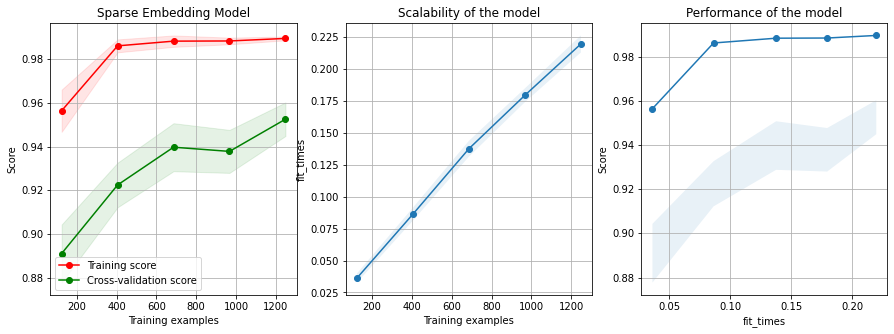

In [ ]:
loaded_model_sparse_embed = joblib.load(saved_model_sparse_embed)
plot_learning_curve(loaded_model_sparse_embed, 'Sparse Embedding Model', loaded_X_train_cleaned, y_train)

## Evaluate on Test Data

In [ ]:
test_eval(loaded_model_sparse_embed, loaded_X_test_cleaned, y_test)


Test set classification report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       583
           1       0.85      0.64      0.73        86

    accuracy                           0.94       669
   macro avg       0.90      0.81      0.85       669
weighted avg       0.94      0.94      0.93       669


F 0.5 Score:  0.7947976878612717


# Feature Engineering

## Pipleline

In [ ]:
X_train_features, feature_names  = featurizer.fit_transform(loaded_X_train_cleaned)
X_test_features, feature_names  = featurizer.fit_transform(loaded_X_test_cleaned)

In [ ]:
fe_pipeline = Pipeline([('xgb', XGBClassifier(random_state=123, weights=6))])

## Model

In [ ]:
params_fe = {'xgb__max_depth': np.arange(2, 50, 4),
             'xgb__n_estimators': np.arange(2, 50, 4),
             'xgb__learning_rate': np.linspace(0.01,1,20),
             'xgb__rate_drop': np.linspace(0, 1, 20)
}
grid_xgb_fe = RandomizedSearchCV(fe_pipeline, params_fe, cv=5, return_train_score=True, error_score='raise')
grid_xgb_fe.fit(X_train_features, y_train)
print(grid_xgb_fe.best_params_)
print(grid_xgb_fe.best_estimator_)
print(grid_xgb_fe.best_score_)
print(grid_xgb_fe.score(X_train_features, y_train))

{'xgb__rate_drop': 0.631578947368421, 'xgb__n_estimators': 38, 'xgb__max_depth': 26, 'xgb__learning_rate': 0.37473684210526315}
Pipeline(steps=[('xgb',
                 XGBClassifier(learning_rate=0.37473684210526315, max_depth=26,
                               n_estimators=38, random_state=123,
                               rate_drop=0.631578947368421, weights=6))])
0.9775641025641025
0.9993589743589744


In [ ]:
saved_model_fe = folder / 'Models/model_fe.pkl'
joblib.dump(grid_xgb_fe.best_estimator_, saved_model_fe)

['/content/drive/MyDrive/BUAN 6342 - Natural Language Processing/Assignments/Assignment 3/Models/model_fe.pkl']

## Learning Curve

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

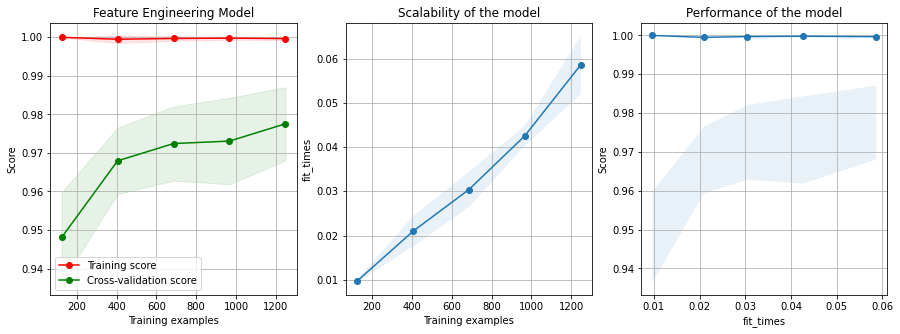

In [ ]:
loaded_model_fe = joblib.load(saved_model_fe)
plot_learning_curve(loaded_model_fe, 'Feature Engineering Model', X_train_features, y_train)

## Evaluate on Test Data

In [ ]:
test_eval(loaded_model_fe, X_test_features, y_test)


Test set classification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       583
           1       0.93      0.92      0.92        86

    accuracy                           0.98       669
   macro avg       0.96      0.95      0.96       669
weighted avg       0.98      0.98      0.98       669


F 0.5 Score:  0.9272300469483569


# Sparse Embedding TFIDF Vectorizer + Feature Engineering

In [ ]:
X_train_final = pd.concat((pd.DataFrame(X_train_clean, columns=['cleaned_text']), 
                           pd.DataFrame(X_train_features, columns=feature_names)),axis=1)
X_test_final = pd.concat((pd.DataFrame(X_test_cleaned, columns=['cleaned_text']), 
                           pd.DataFrame(X_test_features, columns=feature_names)),axis=1)

In [ ]:
sparse_features = Pipeline([('sparse', SparseTransformer())]) 
vectorizer = Pipeline([('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+", ngram_range=(1,4)))]) 

In [ ]:
sparse_features.fit_transform(X_train_final.iloc[:,1:])
vectorizer.fit_transform(X_train_final.iloc[:,0])

<1560x31581 sparse matrix of type '<class 'numpy.float64'>'
	with 43464 stored elements in Compressed Sparse Row format>

In [ ]:
combined_features = ColumnTransformer(transformers=[('tfidf', vectorizer, 'cleaned_text')], remainder=sparse_features)

## Pipleline

In [ ]:
sparse_embed_fe_pipeline = Pipeline([('combined_features',  combined_features),
                                     ('xgb', XGBClassifier(random_state=123, weights=6))])

## Model

In [ ]:
params_sparse_embed_fe = {'combined_features__tfidf__tfidf__max_features': np.linspace(1, feature_length, 30, dtype='int'),
                        #   'vectorizer__min_df': np.linspace(0, 0.2, 5),
                        #   'vectorizer__max_df': np.linspace(0.8, 1, 5),
                          'xgb__max_depth': np.arange(2, 50, 4),
                          'xgb__n_estimators': np.arange(2, 50, 4),
                          'xgb__learning_rate': np.linspace(0.01,1,20),
                          'xgb__rate_drop': np.linspace(0, 1, 20)
}
grid_xgb_spasre_embed_fe = RandomizedSearchCV(sparse_embed_fe_pipeline, params_sparse_embed_fe, cv=5, return_train_score=True, error_score='raise')
grid_xgb_spasre_embed_fe.fit(X_train_final, y_train)
print(grid_xgb_spasre_embed_fe.best_params_)
print(grid_xgb_spasre_embed_fe.best_estimator_)
print(grid_xgb_spasre_embed_fe.best_score_)
print(grid_xgb_spasre_embed_fe.score(X_train_final, y_train))

{'xgb__rate_drop': 0.894736842105263, 'xgb__n_estimators': 22, 'xgb__max_depth': 2, 'xgb__learning_rate': 0.32263157894736844, 'combined_features__tfidf__tfidf__max_features': 2030}
Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=2030,
                                                                                   ngram_range=(1,
                                                                                                4),
                                                                                   token_pattern='[\\S]+'))]),
                                                  'cleaned_text')])),
     

In [ ]:
saved_model_sparse_embed_fe = folder / 'Models/model_sparse_embed_fe.pkl'
joblib.dump(grid_xgb_spasre_embed_fe.best_estimator_, saved_model_sparse_embed_fe)

['/content/drive/MyDrive/BUAN 6342 - Natural Language Processing/Assignments/Assignment 3/Models/model_sparse_embed_fe.pkl']

## Learning Curve

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

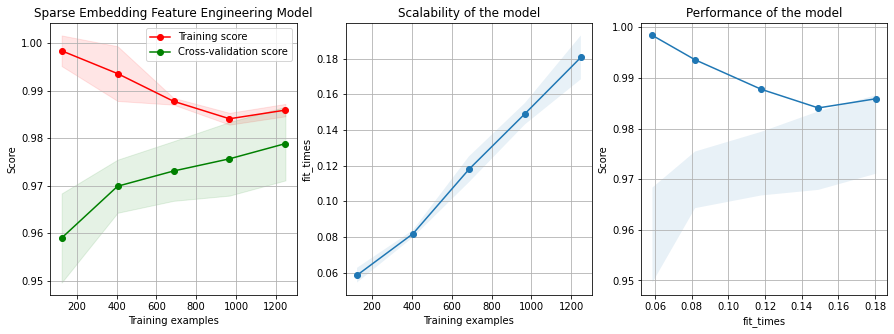

In [ ]:
loaded_model_sparse_embed_fe = joblib.load(saved_model_sparse_embed_fe)
plot_learning_curve(loaded_model_sparse_embed_fe, 'Sparse Embedding Feature Engineering Model', X_train_final, y_train)

## Evaluate on Test Data

In [ ]:
test_eval(loaded_model_sparse_embed_fe, X_test_final, y_test)


Test set classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       583
           1       0.95      0.88      0.92        86

    accuracy                           0.98       669
   macro avg       0.97      0.94      0.95       669
weighted avg       0.98      0.98      0.98       669


F 0.5 Score:  0.935960591133005
